# WM391 PMA Additional Help

## Contents

1. Loading data into colab
2. Template for using PyTorch dataloader
3. Saving check points
4. Loading from check points
5. Some architectures to consider
6. Some useful items to explore
7. Template code for training, evaluation, saving and loading models


> **The code in this file is a template that will give you hints and suggstions on possible options. You need to read understand and modify this code for it to work for your case. It will not run without making changes that correspond to your local file system or GDrive, implementing your chosen model and missing parts.**


*Authors:* Aru Ranjan Singh, Manoj Babu

*Date:* 07/06/2022

In [1]:
# Loading some useful libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from torch.utils.data import Dataset, DataLoader
import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg

## Loading data into colab

One way is to connect your GDrive. 

List of all possible options can be found [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=eikfzi8ZT_rW)

In [ ]:
# Connecting your google drive
from google.colab import drive
drive.mount('/content/drive')

### Extracting a zip file from within colab to a location in GDrive, as uploading single image files can be time consuming

Can be acheived by the following command:
`!unzip "path to the zip file" -d "path to the folder to extract the files"`

Path can be obtained interactively by using the sidebar in colab to locate the folder and clicking the three dots at the end of the folder name as shown in the figure below:

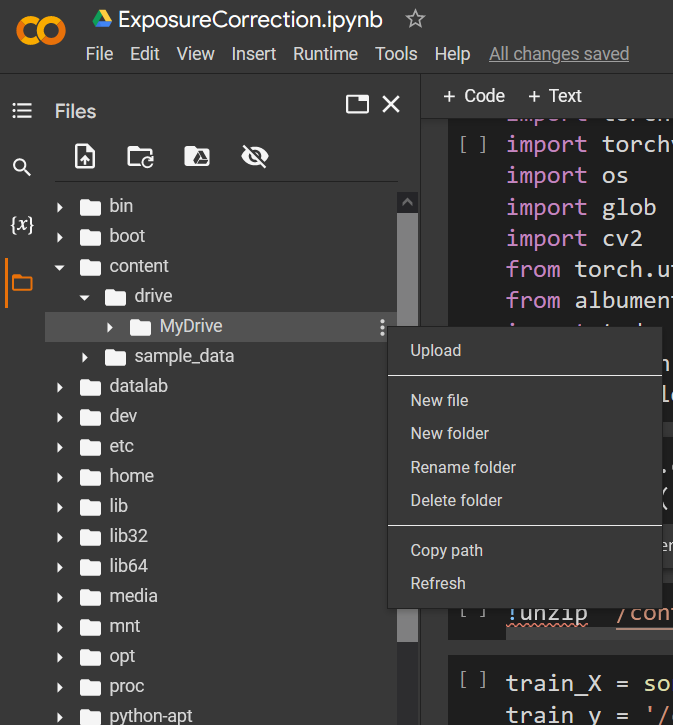

See the example path for my google drive below.

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/exposure_dataset/training.zip" -d "/content/drive/MyDrive/Colab Notebooks/exposure_dataset/training/"

## Template for using PyTorch dataset and dataloader

As pointed out in the lab files pyTorch has a `Dataset` module the helps with loading files. In addition to this we can add image file manipulations/transformations to each file when it is loaded into the model. 

This modules integrates with the `Dataloader` module that makes splitting the dataset into training, testing and batches automatic.  The code in the following code can be used as template  

In [ ]:
# All training files, i.e., Xs
train_X = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/exposure_dataset/training/INPUT_IMAGES/*')) 
# Path to folder containing training files, i.e., Ys 
train_y = '/content/drive/MyDrive/Colab Notebooks/exposure_dataset/training/GT_IMAGES/' 

valid_X = sorted(glob.glob('/content/drive/MyDrive/Colab Notebooks/exposure_dataset/validation/INPUT_IMAGES/*'))
valid_y = '/content/drive/MyDrive/Colab Notebooks/exposure_dataset/validation/GT_IMAGES/'


# defining the custom dataset class 
class LoadDataExposure(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = transforms.Resize(size) # Resizes the input image

    def __getitem__(self, idx): 
        # Each call to LoadDataExposure object will return a image according to the id passed to the object, 
        # each image returend will be the output from this function, you can modify this to add your own transformations or 
        # manipulations. Try to understnad this code and see what is happening here.
        img = cv2.imread(self.images_path[idx])
        img = Image.fromarray(img)
        # img = Image.open(self.images_path[idx])
        img = self.transform(img)
        img = np.transpose(img, (2, 0, 1))
        # img = img/255.0                # can you reason whether this is important or not?
        img = torch.tensor(img)

        image_name = os.path.basename(self.images_path[idx]).split(".")[0]
        image_name = image_name.split("_")
        del image_name[-1]
        best_exp_image_name = "_".join(image_name)
        exp_img_path = self.masks_path + best_exp_image_name +".jpg"
        mask = cv2.imread(exp_img_path)
        mask = Image.fromarray(mask)
        # mask = Image.open(exp_img_path)
        mask = self.transform(mask)
        mask = np.transpose(mask, (2, 0, 1))
        # mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

We can use the above created dataset object in conjuction with a dataloader that will help load in batches automatically.

In [ ]:
# Setting the hyper-parameters THESE VALUES ARE NOT A SUGGESTION, YOU MUST MODIFY THEM ACCORDING TO YOUR CASE
batch_size = 4
num_epochs = 50
lr = 1e-4

In [ ]:
# Creating the dataloader object
train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

## Create your model 


## Some architectures to consider
> Since in this task both input and output are image, a encoder-decoder type architecture will be best suited, a popular option is the uNet. If you want to explore further networks pix2pix and cycleGAN could be useful as well. They all have PyTorch implementations. 

As described in the brief we don't have to create an new architecture, please choose an architecture that is appropriate for the task and demonstrate your understanding of it.

After you define your model, lets call it `exNet` you can move it to GPU. 

As explained in the lab, to enable GPU computaion in Colab by clicking the `Runtime` menu option, then clicking ` change runtime`. *Please refer to previous announcemnts for detailed instructions on how to use a GPU available on your local machine.*

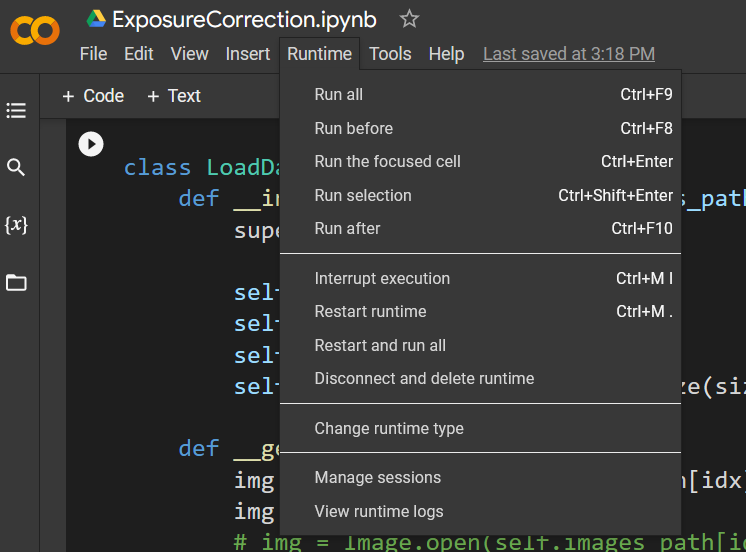

Finally, select GPU from the dialog box.

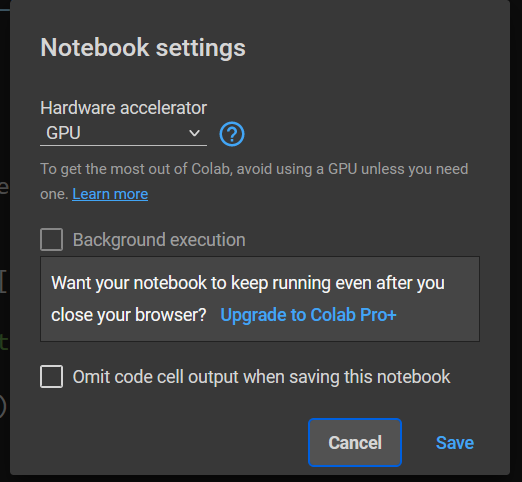

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = exNet()
model = model.to(device)

## Choose your optimiser and loss function

In [ ]:
optimizer = # torch.optim.xxx
loss_fn = # nn.xx

## Saving check points
It is always good to save your model training progress so that if trainig stops for any reason you dont dont have to start from scratch. This is also helpful as your colab session might disconnect if you are inactive for long periods. 
> Official PyTorch help [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html)


In [2]:
# The path where the file will be saved
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/exposure_dataset/checkpoint.pth"


## Defining the training function

### Some key manipuations to consider to make training faster

Work with a smaller dataset, reduce the size of the image so that training can be faster. There are other options available for you to explore on this as well ...


In [ ]:
def train_model(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)
#         x,y=x.type(torch.FloatTensor),y.type(torch.FloatTensor) # what does this do?

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

## Evaluation function

In [ ]:
def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
#             x,y=x.type(torch.DoubleTensor),y.type(torch.DoubleTensor) # what does this do?

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

## Training evaluation and saving loop

In [ ]:
train = []
valid = []

best_valid_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = train_model(model, train_loader, optimizer, loss_fn, device)
    valid_loss = evaluate(model, valid_loader, loss_fn, device)

    train.append(train_loss)
    valid.append(valid_loss)        
    
    if valid_loss < best_valid_loss:
        data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
        print(data_str)

        best_valid_loss = valid_loss
        torch.save(model.state_dict(), checkpoint_path)

    data_str = f'Epoch: {epoch+1:02}\n'
    data_str += f'\tTrain Loss: {train_loss:.3f}\n'
    data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
    print(data_str)

## Loading from check points

In [ ]:
model.load_state_dict(torch.load(checkpoint_path))
# If you just want to use a pretrained model, set the model to eval() mode, 
#so weights are not accidentaly updated or modified
model.eval()

## Refereces
Kaggle